<a href="https://colab.research.google.com/github/minnu351/Truck-Detection-/blob/main/Object_Detection_PrimitiveYolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

oum

References:

*   https://www.kaggle.com/code/k1rsn7/en-car-object-detection-using-yolov8#%F0%9F%93%8A-Model-comparison
*   https://www.kaggle.com/datasets/rohan300557/vehicle-detection
*   https://universe.roboflow.com/roboflow-100/vehicles-q0x2v
*   https://www.kaggle.com/datasets/phuocnguyenxuan/vehicle-detection/data
*   https://www.kaggle.com/datasets/lkergalipatak/vehicle-and-lp-dataset-with-yolov5-annotations/data

###Imports

In [1]:
!pip install ultralytics



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.1/871.1 kB 51.5 MB/s eta 0:00:00


In [2]:
!pip install opendatasets

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
import random
import warnings
warnings.filterwarnings("ignore")
import opendatasets as od
import yaml


In [4]:
od.download("https://www.kaggle.com/datasets/abdallahwagih/cars-detection/data", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thumikimayukha
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/cars-detection


100%|██████████| 38.2M/38.2M [00:03<00:00, 12.7MB/s]


###Converting to standard format

In [6]:
def converterYOLOToCV2(h, w, box):
    """
    The function allows you to transform the object's cordinates for the subsequent correct drawing of them on the image
    Input:
        box - object coordinates in the format [X_center Y_center, width, height]
    Output:
        x_start - X coordinate of the upper left corner
        y_start - Y coordinate of the upper left corner
        x_end - X coordinate of the lower right corner
        y_end - Y coordinate of the lower right corner
    """
    # Get the percentage coordinates of the top left corner
    x_start, y_start = box[0] - box[2] / 2, box[1] - box[3] / 2

    # Get the percentage coordinates of the bottom right corner
    x_end, y_end = box[0] + box[2] / 2, box[1] + box[3] / 2

    # Convert coordinates from percent to pixels
    x_start = int(x_start * w)
    y_start = int(y_start * h)
    x_end = int(x_end * w)
    y_end = int(y_end * h)

    return x_start, y_start, x_end, y_end

In [7]:
def plot_car(image_paths, label_paths):
    """
    The function allows drawing objects on the image
    Input:
        image_paths - path to the folder with images
        label_paths - path to the folder with coordinates of objects on the image
    Output:
        imgsz - size of the square image in pixels
    """
    # Variable containing the size of the square image
    imgsz = 0

    # Create a dictionary with the names of object classes and their colors
    name_and_color_box = {
        '0': ['Ambulance', (255,56,56)],
        '1': ['Bus', (255,157,151)],
        '2': ['Car', (255,112,31)],
        '3': ['Motorcycle', (255,219,150)],
        '4': ['Truck', (207,210,49)]
    }

    # Get all the images and coordinates of the objects in these folders
    images = [f for f in os.listdir(image_paths) if f.endswith('.jpg')]
    labels = [f for f in os.listdir(label_paths) if f.endswith('.txt')]

    # Create a drawing with nested graphs for each image
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for x in range(0, 4):
        for y in range(0, 4):
            img_index = len(images)//4*x+y*2

            if img_index >= len(images):
                break  # Stop if we run out of images

            # Upload the image
            image = cv2.imread(f'{image_paths}/{images[img_index]}')

            # Convert the color palette of the photo from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Corresponding label file
            label_file = images[img_index].replace('.jpg', '.txt')
            label_path = os.path.join(label_paths, label_file)

            # Check if the label file exists
            if os.path.exists(label_path):
                # Open the object markup file
                with open(label_path, 'r') as r:
                    # Read a line from the file
                    lines = r.readlines()
                    for line in lines:
                        # Get the class in the image
                        label = line.split()[0]

                        # Get the height and width of the image
                        h, w, _ = image.shape

                        # Get the coordinates of the object
                        x_start, y_start, x_end, y_end = converterYOLOToCV2(
                            h, w,
                            [float(item) for item in line.split()[1:]]
                        )

                        # Draw the boundaries of the object on the image
                        image = cv2.rectangle(
                            img=image,
                            pt1=(x_start, y_start),
                            pt2=(x_end, y_end),
                            color=name_and_color_box[label][1],
                            thickness=2
                        )

                        # Add the class text to the image
                        image = cv2.putText(
                            img=image,
                            text=name_and_color_box[label][0],
                            org=(x_start, y_start-10),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=min(1, max(3, int(w/500))),
                            color=name_and_color_box[label][1],
                            thickness=min(2, max(10, int(w/50)))
                        )

                        # Save the dimensions of the largest image
                        if h == w and imgsz < h:
                            imgsz = h

            # Display the current image on the corresponding subplane
            axes[x][y].imshow(image)
            axes[x][y].axis('off')

    # Nastrom distance between subplots
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    return imgsz

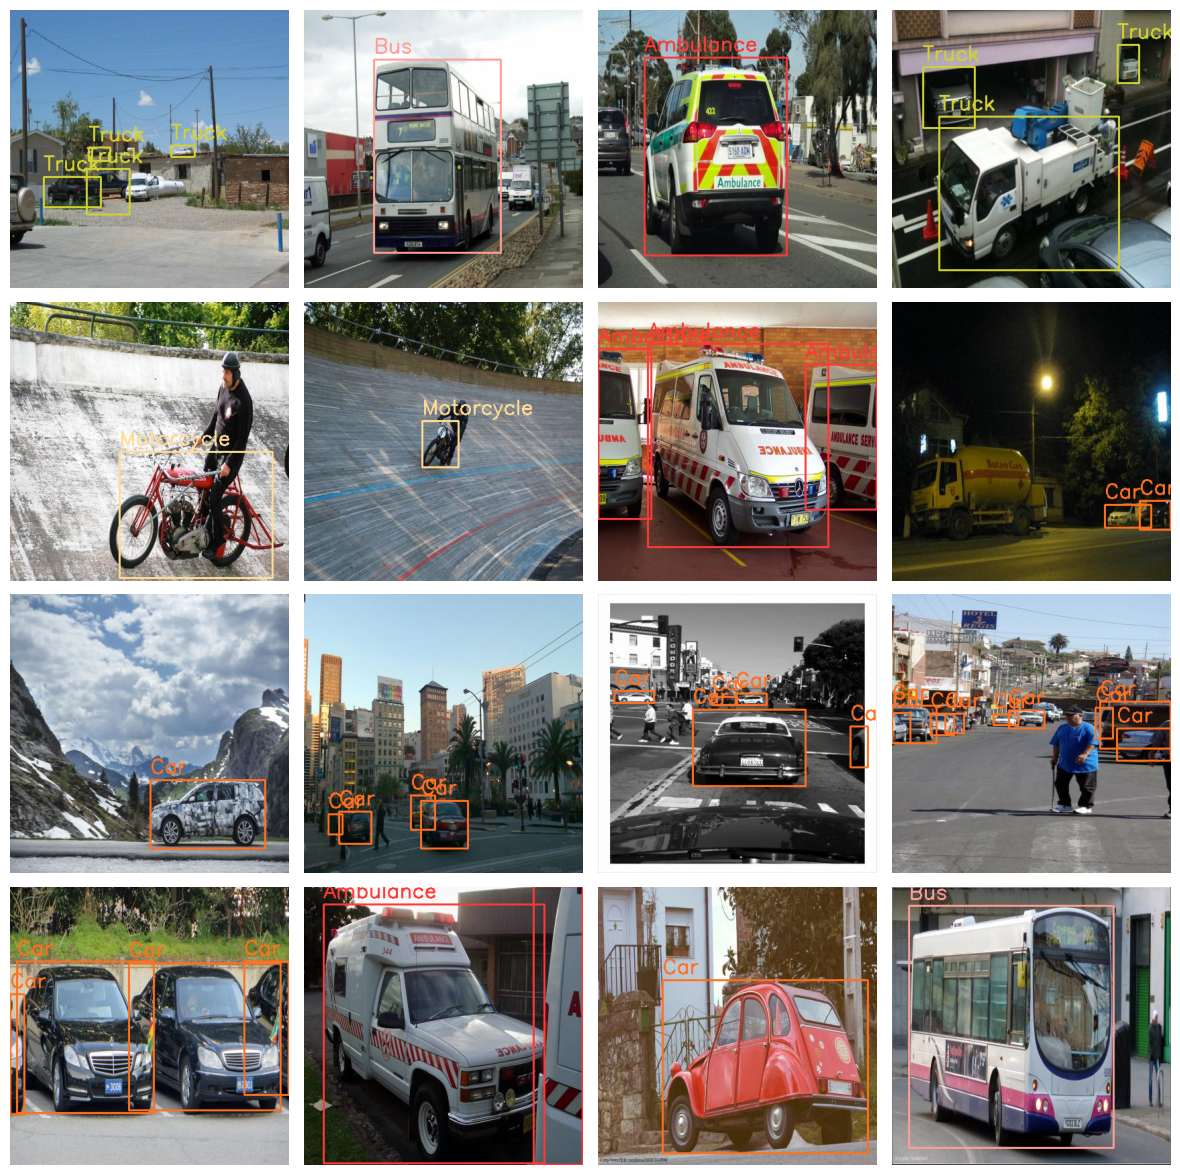

In [8]:
imgsz = plot_car(r'/content/cars-detection/Cars Detection/train/images', r'/content/cars-detection/Cars Detection/train/labels')

In [11]:
import yaml

# Load the existing YAML file
yaml_file_path = '/content/cars-detection/Cars Detection/data.yaml'

with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

# Update the paths
data['train'] = '/content/cars-detection/Cars Detection/train/images'
data['val'] = '/content/cars-detection/Cars Detection/valid/images'
data['test'] = '/content/cars-detection/Cars Detection/test/images'

# Save the updated YAML file
with open(yaml_file_path, 'w') as file:
    yaml.safe_dump(data, file)


###Model Training

In [12]:
epoch_traning = 30
path_yalm = "/content/cars-detection/Cars Detection/data.yaml" # Path to the yalm file
patience = 5

In [13]:
model = YOLO("yolov8n.yaml")
model.train(data=path_yalm, epochs=epoch_traning, imgsz=imgsz, patience=patience)

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/cars-detection/Cars Detection/data.yaml, epochs=30, time=None, patience=5, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

100%|██████████| 755k/755k [00:00<00:00, 92.5MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 393MB/s]


AMP: checks passed ✅


train: Scanning /content/cars-detection/Cars Detection/train/labels... 878 images, 0 backgrounds, 0 corrupt: 100%|██████████| 878/878 [00:00<00:00, 1309.50it/s]

train: New cache created: /content/cars-detection/Cars Detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/cars-detection/Cars Detection/valid/labels... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<00:00, 1203.45it/s]

val: New cache created: /content/cars-detection/Cars Detection/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.05G      3.388       4.32      4.218         46        416: 100%|██████████| 55/55 [00:07<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

                   all        250        454    0.00418      0.518    0.00743    0.00201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         1G      3.332      4.054      3.973         49        416: 100%|██████████| 55/55 [00:05<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  8.00it/s]

                   all        250        454    0.00421      0.505     0.0126    0.00312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.998G      3.101      3.824      3.637         56        416: 100%|██████████| 55/55 [00:04<00:00, 12.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.11it/s]

                   all        250        454    0.00368      0.636    0.00653    0.00222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         1G      2.882      3.771      3.358         44        416: 100%|██████████| 55/55 [00:04<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]

                   all        250        454     0.0159      0.145     0.0105    0.00298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.996G      2.701      3.607      3.111         50        416: 100%|██████████| 55/55 [00:04<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.12it/s]

                   all        250        454     0.0388      0.165     0.0253    0.00717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.992G      2.547      3.528      2.954         47        416: 100%|██████████| 55/55 [00:05<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.10it/s]

                   all        250        454      0.228      0.158     0.0261    0.00852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      0.96G      2.391      3.358      2.796         48        416: 100%|██████████| 55/55 [00:04<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.54it/s]

                   all        250        454     0.0481     0.0621      0.038     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      0.99G      2.268        3.3      2.694         48        416: 100%|██████████| 55/55 [00:04<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.60it/s]

                   all        250        454      0.076      0.135     0.0501     0.0202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.996G       2.19      3.209      2.617         47        416: 100%|██████████| 55/55 [00:04<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]

                   all        250        454      0.087      0.144     0.0773     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.996G       2.14      3.144      2.554         46        416: 100%|██████████| 55/55 [00:04<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        250        454      0.123     0.0603     0.0746     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.996G       2.07      3.101      2.489         46        416: 100%|██████████| 55/55 [00:04<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.71it/s]

                   all        250        454      0.132      0.219      0.104     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.01G      2.066      3.063      2.478         41        416: 100%|██████████| 55/55 [00:04<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        250        454     0.0936       0.23     0.0883     0.0414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.996G      1.985       2.98      2.405         52        416: 100%|██████████| 55/55 [00:04<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.24it/s]

                   all        250        454      0.138      0.167      0.118      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.992G      1.901      2.912      2.348         46        416: 100%|██████████| 55/55 [00:04<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.45it/s]

                   all        250        454      0.151      0.228       0.12     0.0535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      0.96G      1.904      2.891      2.321         68        416: 100%|██████████| 55/55 [00:04<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.19it/s]

                   all        250        454      0.198      0.226       0.13     0.0697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.988G      1.853      2.818      2.303         45        416: 100%|██████████| 55/55 [00:04<00:00, 11.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.90it/s]

                   all        250        454       0.19       0.18      0.118     0.0496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.994G      1.827      2.813      2.256         59        416: 100%|██████████| 55/55 [00:04<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        250        454      0.131      0.183       0.12     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.998G       1.81      2.724      2.227         63        416: 100%|██████████| 55/55 [00:04<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.65it/s]

                   all        250        454      0.175       0.16      0.132     0.0687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      0.99G      1.776      2.709      2.203         54        416: 100%|██████████| 55/55 [00:04<00:00, 12.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]

                   all        250        454      0.164      0.217      0.136     0.0731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.967G      1.754      2.679      2.197         41        416: 100%|██████████| 55/55 [00:04<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

                   all        250        454      0.166      0.209      0.149     0.0841


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.992G      1.623      2.743      2.107         24        416: 100%|██████████| 55/55 [00:05<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]

                   all        250        454      0.211       0.28      0.181      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      0.96G      1.587      2.605      2.095         20        416: 100%|██████████| 55/55 [00:04<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]

                   all        250        454      0.207      0.315      0.176      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.958G       1.56      2.504      2.061         19        416: 100%|██████████| 55/55 [00:04<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        250        454      0.318      0.221      0.186      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.994G      1.533      2.448      2.024         22        416: 100%|██████████| 55/55 [00:04<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.56it/s]

                   all        250        454      0.272      0.329      0.219      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.992G      1.496      2.378      1.987         26        416: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.58it/s]

                   all        250        454      0.235      0.321      0.215      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      0.96G      1.481      2.334      1.966         29        416: 100%|██████████| 55/55 [00:04<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.24it/s]

                   all        250        454      0.256      0.358       0.26      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.958G      1.501      2.331      1.976         32        416: 100%|██████████| 55/55 [00:04<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.82it/s]

                   all        250        454      0.306      0.341      0.265      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.992G      1.457      2.293      1.965         27        416: 100%|██████████| 55/55 [00:04<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.88it/s]

                   all        250        454      0.285      0.383      0.279      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.992G      1.458      2.241      1.923         42        416: 100%|██████████| 55/55 [00:05<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.48it/s]

                   all        250        454      0.346      0.309      0.301      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.958G      1.434      2.215      1.911         25        416: 100%|██████████| 55/55 [00:04<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.72it/s]

                   all        250        454      0.264      0.341      0.271      0.173



30 epochs completed in 0.057 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


                   all        250        454      0.346      0.309      0.301      0.197
             Ambulance         50         64       0.53      0.469      0.546      0.386
                   Bus         30         46      0.268      0.435      0.368      0.231
                   Car         90        238      0.329      0.247      0.181      0.106
            Motorcycle         42         46      0.343      0.261      0.277      0.172
                 Truck         38         60      0.258      0.133      0.132     0.0902
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x783309ec6950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [15]:
def get_metrics():
    """
    The function allows you to get data about metrics of all models
    Output:
        metrics - DataFrame containing metrics of all models
    """
    name_model = 'YOLOV8n'

    # DaraFrame for metrics
    metrics = pd.DataFrame()

    df = pd.read_csv(f'/content/runs/detect/train/results.csv').astype(np.float32)

    # Selecting metrics
    df = df[[(column) for column in df.columns if 'val' in column or 'metrics' in column and 'metrics/mAP50-95(B)' not in column]]
    df.columns = [f'{name_model}/{column}'.replace(' ', '') for column in df.columns]

    # Connecting model metrics to other metrics
    metrics = pd.concat([metrics, df], axis=1)

    return metrics

get_metrics()

YOLOV8n/metrics/precision(B)  YOLOV8n/metrics/recall(B)  \
0                        0.00418                    0.51782   
1                        0.00421                    0.50500   
2                        0.00368                    0.63603   
3                        0.01591                    0.14459   
4                        0.03880                    0.16475   
5                        0.22842                    0.15758   
6                        0.04810                    0.06209   
7                        0.07604                    0.13513   
8                        0.08698                    0.14384   
9                        0.12332                    0.06031   
10                       0.13173                    0.21857   
11                       0.09356                    0.23006   
12                       0.13848                    0.16745   
13                       0.15124                    0.22797   
14                       0.19755                    0.22638   
15                       0.19043                    0.17998   
16                       0.13062                    0.18261   
17                       0.17541                    0.15989   
18                       0.16412                    0.21657   
19                       0.16601                    0.20899   
20                       0.21062                    0.28015   
21                       0.20720                    0.31492   
22                       0.31823                    0.22135   
23                       0.27216                    0.32893   
24                       0.23487                    0.32058   
25                       0.25570                    0.35843   
26                       0.30562                    0.34141   
27                       0.28481                    0.38329   
28                       0.34616                    0.30898   
29                       0.26372                    0.34077   

    YOLOV8n/metrics/mAP50(B)  YOLOV8n/val/box_loss  YOLOV8n/val/cls_loss  \
0                    0.00743                3.0957                4.0904   
1                    0.01258                3.0565                4.5172   
2                    0.00653                2.8331                4.5278   
3                    0.01051                2.6811                8.8979   
4                    0.02529                2.6333                6.0473   
5                    0.02612                2.5198                5.8150   
6                    0.03800                2.2529                3.8030   
7                    0.05005                2.2084                3.6580   
8                    0.07734                2.1243                3.2437   
9                    0.07464                2.0516                3.1890   
10                   0.10429                2.0052                3.0595   
11                   0.08830                2.0387                3.1336   
12                   0.11840                1.9815                3.0459   
13                   0.11997                1.9478                3.0737   
14                   0.13034                1.9727                2.9499   
15                   0.11814                1.9650                3.0372   
16                   0.12016                1.8664                2.8859   
17                   0.13239                1.8407                2.8455   
18                   0.13639                1.8376                2.8335   
19                   0.14914                1.8338                2.7822   
20                   0.18067                1.7629                2.7317   
21                   0.17608                1.6812                2.6331   
22                   0.18570                1.7421                2.6006   
23                   0.21897                1.7238                2.5449   
24                   0.21460                1.6881                2.5252   
25                   0.25971                1.6801                2.4651  

###Results

In [28]:
model = YOLO("/content/runs/detect/train/weights/best.pt")

In [29]:
def car_detect(img_path):
    """
    The function allows you to get an image with an object marked on it
    Input:
        img_path - path to the image
    Output:
        detect_img - image with marked object
    """
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

    return detect_img


0: 416x416 1 Bus, 6.7ms
Speed: 0.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 (no detections), 6.6ms
Speed: 1.5ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 (no detections), 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 (no detections), 8.7ms
Speed: 1.2ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 2 Cars, 6.2ms
Speed: 1.2ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 (no detections), 6.4ms
Speed: 1.6ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 (no detections), 6.7ms
Speed: 1.5ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Bus, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shap

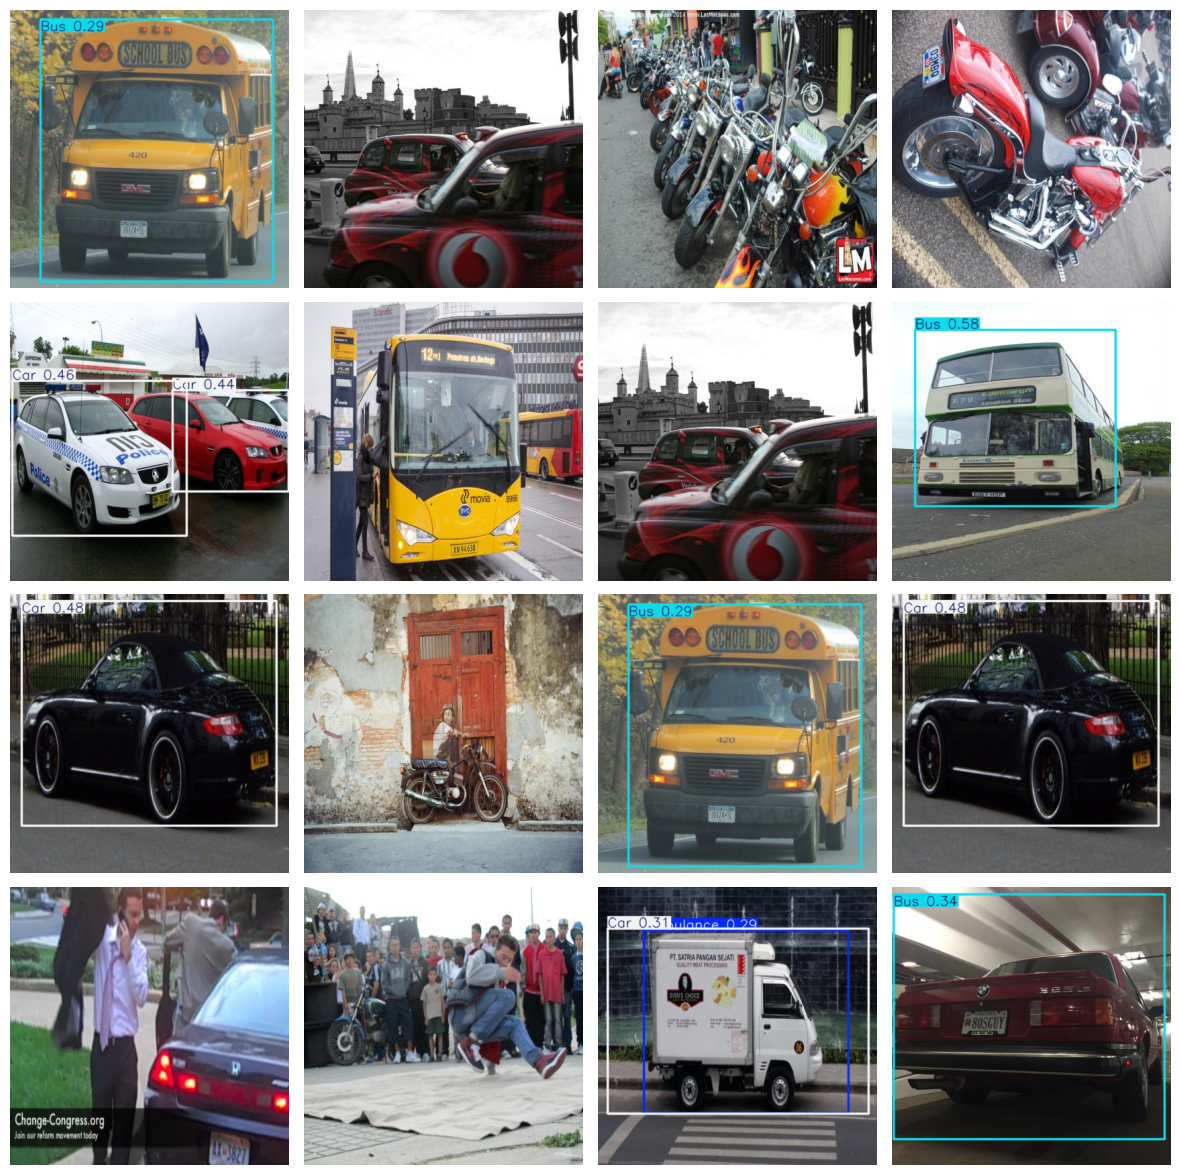

In [30]:
# Define the directory where custom images will be stored
custom_image_dir = '/content/cars-detection/Cars Detection/test/images'

# Get a list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a drawing with nested graphs for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate the selected images and plot each of them
for i, img_file in enumerate(selected_images):

    # Calculate the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4

    # Load the current image and start object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = car_detect(img_path)

    # Display the current image on the corresponding subplane
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Nastrom distance between subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)


0: 480x640 (no detections), 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.7ms
Speed: 3.2ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.8ms
Speed: 3.3ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.9ms
Speed: 3.3ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


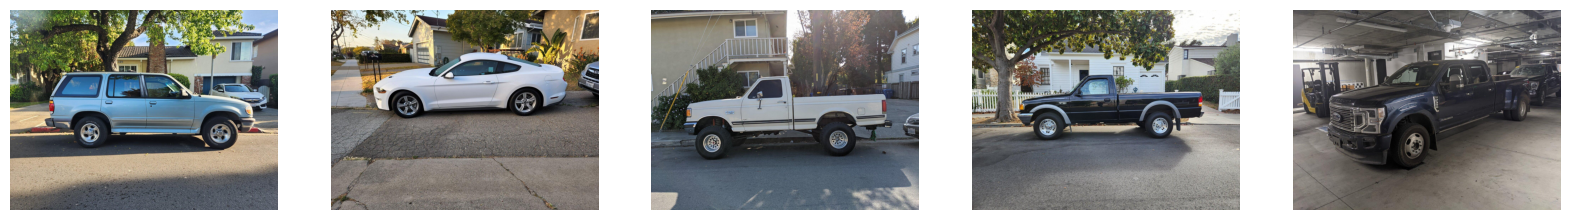

In [31]:
import os
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import cv2

'''def car_detect(img_path):
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    return detect_img'''

# Load the YOLOv8n model
model = YOLO("yolov8n.yaml")

base_url = 'https://nkj2po029e.execute-api.us-west-2.amazonaws.com/prod/image'

output_dir = '/content/processed_images'
os.makedirs(output_dir, exist_ok=True)

images = []
for i in range(1, 6):
    try:
        response = requests.get(base_url)
        response_json = response.json()
        body = json.loads(response_json['body'])
        filename = body['filename']
        image_url = body['image_url']

        image_response = requests.get(image_url)
        image = Image.open(BytesIO(image_response.content))

        image_path = os.path.join(output_dir, filename)
        image.save(image_path)

        processed_image = car_detect(image_path)
        images.append(processed_image)
    except Exception as e:
        pass

fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for idx, ax in enumerate(axes.ravel()):
    if idx < len(images):
        ax.imshow(images[idx])
        ax.axis('off')

plt.show()
